In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# If running on Apple Silicon or CUDA is available, use the GPU.
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)
device = torch.device(device)

mps


# Tutorial: Pytorch Models on the Hook
### Or: How to look inside pytorch models.

### What is a hook?
- A hook is a function that is executed during the forward or backward pass of a pytorch module
- It can track the input, output or gradients of a module.

### For what can I use hooks?
- visualizing inputs, outputs or gradients of specific Module layers
- debugging of vanishing gradients, loss = NaN, ...
- modifying gradients on the fly

## Forward Hook
With a forward hook, you can visualize the output of a specific layer in your neural network. It is called `forward` hook, because it attaches a hook to the forward pass of the network. In the forward pass, the input `x` is passed in forward direction through the `model` to compute the `output`. During this process, the hook provides you acces to the input and output of the layer on which you registered it.

To use a forward hook, you have to do the following steps:
- define a function `forward_hook` that does whatever you want to do (e.g. print values, plot something, store the values, ...)
- register this function onto the specific layer of the model which input/output values you want to extract
- pass some data through the model to activate the hook
- unregister the hook to prevent memory leaks

In the following, we will go through these steps at the example of a simple feed-forward neural network and just print the module name during the forward hook to illustrate the basic functionality:

In [3]:
# Define a simple neural network
class SimpleNet(torch.nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = torch.nn.Linear(10, 5)
        self.fc2 = torch.nn.Linear(5, 2)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the network
model = SimpleNet()

# Define a forward hook function
def forward_hook(module, input_vals, output_vals):
    print(f"Forward hook executed on module {module.__class__.__name__}")

# Register the forward hook to a specific module
hook_handle = model.fc1.register_forward_hook(forward_hook)


In [4]:
# Generate random input
x = torch.randn(1, 10)

# Pass input through the model
output = model(x)

# Unregister hooks to prevent memory leaks
hook_handle.remove()

Forward hook executed on module Linear


Note that the hook does not get activated upon registering it to the layer, but only when some input is passed through the model.

Of course, we are not necessarily interested in the module name, but in the actual input or output values of the specific layer. Therefore, we detach the input, put it on the CPU, flatten it and plot its values.
The plot appears when we pass the input through the model and the hook is activated.

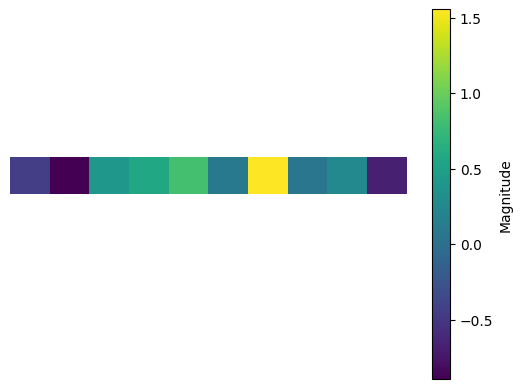

In [5]:
# Define a forward hook for visualization
def activation_visualization_hook(module, input_vals, output_vals):
    # Assuming input is a single tensor
    activations = input_vals[0].detach().cpu().flatten()
    grid_X, grid_Y = np.meshgrid(np.arange(len(activations)+1), [0,1])
    plt.pcolormesh(grid_X, grid_Y, input_vals[0].detach().cpu())
    plt.colorbar(label='Magnitude')
    plt.xlabel("Activations")
    plt.ylim(-5, 5)
    plt.axis('off')
    plt.show()

# Register the hook
activation_hook = model.fc1.register_forward_hook(activation_visualization_hook)

# Pass input through the model
output = model(x)

# Unregister the hook
activation_hook.remove()

It might be impractical to include the plotting durectly in the hook since we might want to collect the activations over multiple layers and visualize the values together.

Therefore, we extend the code with the following steps:
- define a global class `SaveOutput` that collects the hook values
- loop over the modules of the network 
- register forward hooks on all layers of interest by passing an instance of the `SaveOutput` class
- save the hook handles in a list such that we can later remove them

To make this example more illustrative, we switch from a simple neural network to a Resnet34 that was trained on the ImageNet1K dataset.

In [6]:
from torchvision.models import resnet34
from torchvision import transforms
from PIL import Image

In [7]:
# Define class to collect hook values
class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []


save_output = SaveOutput()

# Load multi-layer model
resnet = resnet34(weights='IMAGENET1K_V1')
resnet = resnet.to(device)

hook_handles = []
for layer in resnet.modules():
    # Register all hooks for Conv2d layers
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)

Before passing data through the Resnet, we can verify that the hooks haven't been called yet by looking at the `save_outputs` instance and checking whether some outputs have been stored already.

In [8]:
print("Before hook was called:", len(save_output.outputs))

Before hook was called: 0


Now, we load, visualize, and pre-process an image of a cat and pass it through the model which activates the hooks:

After calling hook: 36


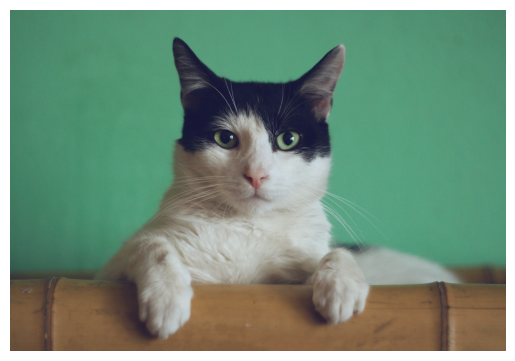

In [9]:
image = Image.open('cat.jpg')
plt.imshow(image)
plt.axis('off')
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
X = transform(image).unsqueeze(dim=0).to(device)

out = resnet(X)

print("After calling hook:", len(save_output.outputs))

# Remove hooks
for h in hook_handles:
    h.remove()

Since `save_outputs.output` now contains the output values of the subsequent Resnet layers, we can visualize them in one figure:

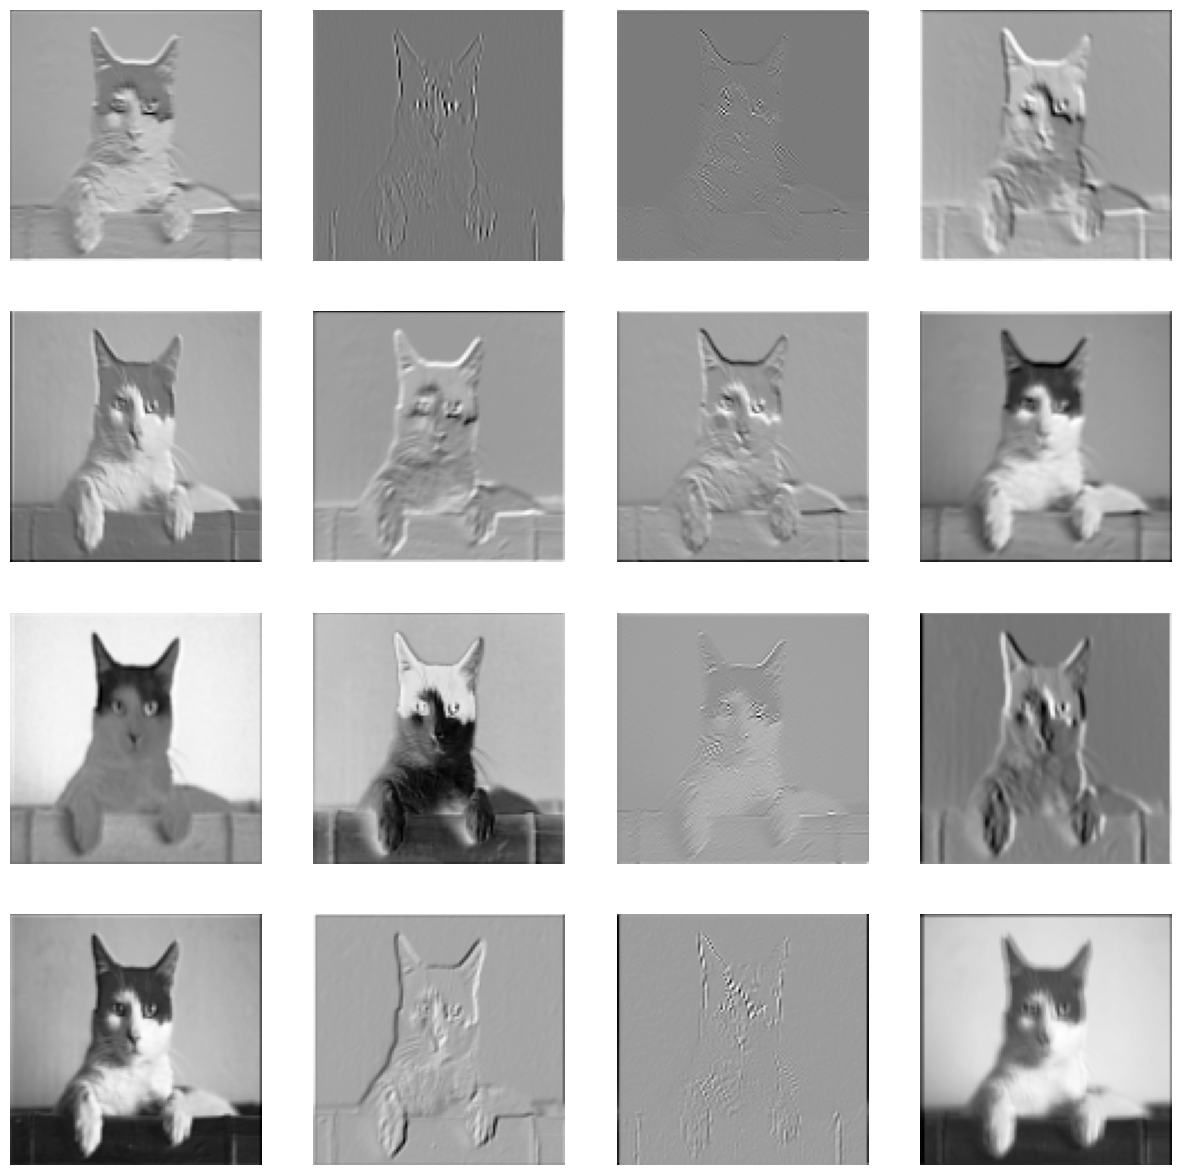

In [10]:
# Visualize inputs to individual layers
images = save_output.outputs[0].detach().to('cpu').numpy()

with plt.style.context("seaborn-v0_8-white"):
    plt.figure(figsize=(15, 15), frameon=False)
    for idx in range(16):
        plt.subplot(4, 4, idx+1)
        plt.imshow(images[0, idx])
        plt.axis('off');

## Backward Hook
With a backward hook, you can access the values of the gradients that are updated during the backward pass. 
There, the gradient from the output is accumulated and passed through the last layer to the second-to-last layer, etc. until the trainable parameters in all layers have been updated.

Using backward hooks might be helpful to use when you want to investigate problems such as vanishing or exploding gradients.

### Visualizing gradients
In order to visualize the gradients, we need to look at the following steps:
- define a class to save the gradients of the backward hook
- load an example image as well as a label based on which the loss can be calculated and the backward pass can be performed. We select the `281: 'tabby, tabby cat'` label from the [list of imagenet1k labels](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)
- register the hooks on the layers of interest and save their handles for removal
- calculate the forward pass and calculate the loss with the predicted label as well as the true label
- perform the backward pass during which the backward hooks get activated
- remove the hooks to prevent memory issues

In [11]:
# Define class to collect hook values
class SaveGrad:
    def __init__(self):
        self.grad_inputs = []
        self.grad_outputs = []
        
    def __call__(self, module, grad_in, grad_out):
        self.grad_inputs.append(grad_in)
        self.grad_outputs.append(grad_out)
        
    def clear(self):
        self.grad_inputs = []
        self.grad_outputs = []

In [12]:
# Load & transform image
image = Image.open('cat.jpg')
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
X = transform(image).unsqueeze(dim=0).to(device)

# Label: 281: 'tabby, tabby cat'
Y = torch.zeros([1,1000], device=device)
Y[:,281] = 1

# Load multi-layer model
resnet = resnet34(weights='IMAGENET1K_V1')
resnet = resnet.to(device)

save_grad = SaveGrad()

# Register backward hooks
hook_handles_bw = []
for layer in resnet.modules():
    # Register all hooks for Conv2d layers
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        handle = layer.register_full_backward_hook(save_grad)
        hook_handles_bw.append(handle)

# Forward pass
out = resnet(X)
loss = torch.nn.functional.cross_entropy(out, Y)

# Backward pass
loss.backward()

# Remove hooks
for h in hook_handles_bw:
    h.remove()

With the gradient values stored in `save_grad`, we can access the gradient inputs and outputs and visualize them in histograms. For convenience, we just plot the first 3 layers:

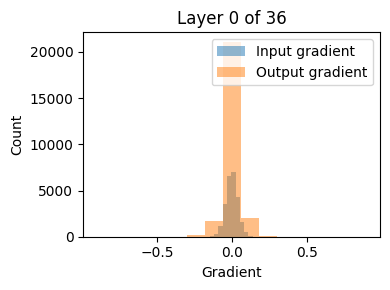

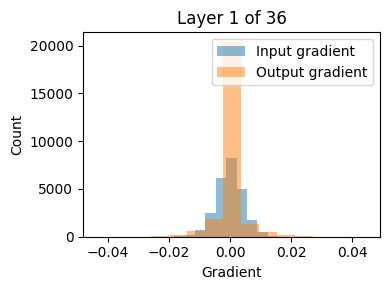

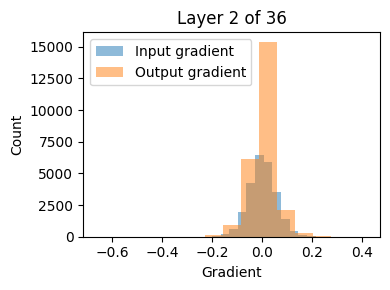

In [13]:
# Visualize gradients of individual layers
for i in range(3):
    grads_in = save_grad.grad_inputs[i][0].detach().to('cpu').numpy()
    grads_out = save_grad.grad_outputs[i][0].detach().to('cpu').numpy()
    plt.figure(figsize=(4,3))
    plt.hist(grads_in.flatten(), bins=15, alpha=0.5, label="Input gradient")
    plt.hist(grads_out.flatten(), bins=15, alpha=0.5, label="Output gradient")
    plt.legend()
    plt.xlabel("Gradient")
    plt.ylabel("Count")
    plt.title(f"Layer {i} of {len(save_grad.grad_inputs)}")
    plt.tight_layout()
    plt.show()

### Modifying gradients
Instead of just saving the gradient values, you might be interested in modifying the gradient for experiments.
In this case, you can define a class method that not only stores the gradient values, but also modifies them. In this example, we just replace the gradients by 1. Now, you need to add a `return` to the method such that the gradient is used in the layer that is next in the backward pass.

In [15]:
# Define class for gradient modification
class ModifyGrad:
    def __init__(self):
        self.grad_inputs = []
        self.grad_outputs = []
        self.grad_inputs_modified = []
        
    def __call__(self, module, grad_in, grad_out):
        self.grad_inputs.append(grad_in)
        self.grad_outputs.append(grad_out)
        # Modified output gradient
        if grad_in[0] is not None:
            modified_grad = torch.ones_like(grad_in[0])
            self.grad_inputs_modified.append(modified_grad)

            return (modified_grad, )
        
    def clear(self):
        self.grad_inputs = []
        self.grad_outputs = []
        self.grad_inputs_modified = []


modify_grad = ModifyGrad()

# Register backward hooks
hook_handles_bw = []
for layer in resnet.modules():
    # Register all hooks for Conv2d layers
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        handle = layer.register_full_backward_hook(modify_grad)
        hook_handles_bw.append(handle)

# Forward pass
out = resnet(X)
loss = torch.nn.functional.cross_entropy(out, Y)

# Backward pass
loss.backward()

# Remove hooks
for h in hook_handles_bw:
    h.remove()

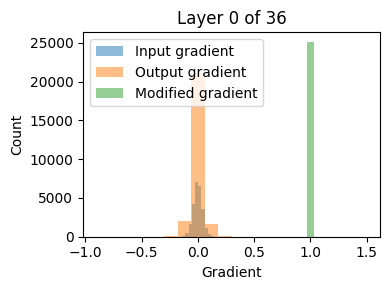

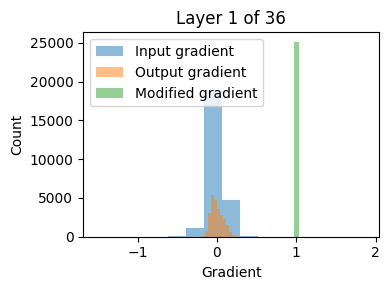

In [29]:
# Visualize gradients of individual layers
for i in range(2):
    grads_in = modify_grad.grad_inputs[i][0].detach().to('cpu').numpy()
    grads_out = modify_grad.grad_outputs[i][0].detach().to('cpu').numpy()
    grads_mod = modify_grad.grad_inputs_modified[i][0].detach().to('cpu').numpy()
    plt.figure(figsize=(4,3))
    plt.hist(grads_in.flatten(), bins=15, alpha=0.5, label="Input gradient")
    plt.hist(grads_out.flatten(), bins=15, alpha=0.5, label="Output gradient")
    plt.hist(grads_mod.flatten(), bins=15, alpha=0.5, label="Modified gradient")
    plt.legend()
    plt.xlabel("Gradient")
    plt.ylabel("Count")
    plt.title(f"Layer {i} of {len(save_grad.grad_inputs)}")
    plt.tight_layout()
    plt.show()

### Order in which hooks are called
1. hooks are registered to PyTorch `Tensor`s
2. pre-forward hooks are registered to `Node` if `Node` is executed (optionally update inputs)
3. inputs to be used by backward hooks captured (→ generates new set of inputs)
4. `forward()` called
5. outputs to be used by backward hooks captured (→ generates new set of outputs)
6. forward hooks (optionally update outputs)

### List of available hooks

- **autograd hooks**
    - tensor gradient hooks
    `Tensor.register_hook(fn)`
    → called every time a gradient for this Tensor is computed
    (optional: return new value for the gradient that will be used in autograd instead of the current value)
    - autograd node gradient hook
    `Node.register_hook(fn)`
    → function called every time this node is executed and return gradients w.r.t. the inputs
    - autograd pre-gradient hook [(new in 2023)](https://dev-discuss.pytorch.org/t/recent-autograd-hooks-improvements/1032)
    → fires directly after tensor hooks
- **torch.nn hooks**
    - hooks for a module
        - pre-forward hook
        `Module.register_forward_pre_hook(fn)`
        → get input values just before evaluation of `module.forward` method
        - forward hook
        `Module.register_forward_hook(fn)`
        → get input values just after evaluation of `module.forward` method
        - backward hook
        `Module.register_full_backward_hook(fn)`
        → get value of gradients w.r.t. all inputs and outputs of the module
    - global hooks: same as module hooks, but affect every module that runs
        - pre-forward hook
        `nn.modules.module.register_forward_pre_hook(fn)`
        → get the input value just before the evaluation of the `Module.forward` method for every Module that runs
        - forward hook
        `nn.modules.module.register_forward_hook(fn)`
        → get the input value just after the evaluation of the `Module.forward` method for every Module that runs
        - backward hook
        `nn.modules.module.register_full_backward_hook(fn)`
        → get the value of the gradients wrt to all inputs and output of the Module for every Module that runs
        ! `register_backward_hook()` is deprecated
- **torch.package**
    - can be used to alter the behavior of the packager with respect to how dependencies are captured (included in the package, included as dependency, mocked).
    - extern hook
    `register_extern_hook(hook)`
    → called each time a module matches agains an `extern()` pattern
    - intern hook
    `register_intern_hook(hook)`
    → called each time a module matches agains an `intern()` pattern
    - mock hook
    `register_mock_hook(hook)`
    → called each time a module matches agains a `mock()` pattern
- **Distributed hooks**
    - comm hook
    `DistributedDataParallel.register_comm_hook(state, hook)`
    → allows the user to alter how the gradients are accumulated in DDP to allow experimenting with more complex algorithms.

References:
- PyTorch documentation: [Hooks Part 1](https://dev-discuss.pytorch.org/t/pytorch-hooks-part-1-all-the-available-hooks/246), [Hooks Part 2](https://dev-discuss.pytorch.org/t/pytorch-hooks-part-2-nn-module-hooks/250), [Hooks Improvement 2023](https://dev-discuss.pytorch.org/t/recent-autograd-hooks-improvements/1032), [Hooks for autograd saved tensors](https://pytorch.org/tutorials/intermediate/autograd_saved_tensors_hooks_tutorial.html)
- Tutorials: [here](https://github.com/elliotwaite/pytorch-hooks-tutorial), [forward hook](https://github.com/cosmic-cortex/pytorch-hooks-tutorial), [here](https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/), [short one](https://medium.com/the-dl/how-to-use-pytorch-hooks-5041d777f904)
- Package by Nasim Rahaman: [deborker](https://github.com/nasimrahaman/torch-deborker/blob/main/tests/test_tracer.py)

For some coding parts of this tutorial, e.g. loading models and preprocessing data, chatGPT was used.